In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Part I: SQL

In [2]:
# SQLite database
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

In [3]:
# Player Table
cursor.execute("""CREATE TABLE Player (Account_ID INTEGER PRIMARY KEY, First_Name TEXT, Last_Name TEXT,
                                       Life_Time_Spins TEXT, Registration_Date TEXT, Last_Login_Date TEXT,
                                       Country TEXT, Game TEXT)""")

# inserting values
cursor.executemany("""INSERT INTO Player VALUES (?, ?, ?, ?, ?, ?, ?, ?)""",
                   [(1, 'Jhon', 'Abraham', '1,500', '01/01/2021', '22/03/2021', 'Germany', 'Slot'),
                    (2, 'Micheal', 'Clarke', '700', '01/01/2021', '01/04/2021', 'Netherland', 'Poker'),
                    (3, 'Roy', 'Thomas', '700', '01/02/2021', '15/03/2021', 'USA', 'backgammon'),
                    (4, 'Tom', 'Jose', '2', '17/03/2021', '18/03/2021', 'Israel', 'Slot'),
                    (5, 'Jerry', 'Pinto', '37', '22/04/2021', '28/04/2021', 'France', 'Poker'),
                    (6, 'Philip', 'Mathew', '1,846', '01/05/2021', '03/05/2021', 'USA', 'backgammon'),
                    (7, 'Josh', 'Wilson', '547', '18/04/2021', '14/05/2021', 'USA', 'Slot'),
                    (8, 'Patric', 'Burk', '1,899', '28/04/2021', '28/04/2021', 'Austria', 'Slot')])

In [4]:
# Daily Activity Table
cursor.execute("""CREATE TABLE Daily_Activity (Account_ID INTEGER, Date TEXT, Platform TEXT, First_Name TEXT,
                                               Last_Name TEXT, Revenue TEXT,
                                               FOREIGN KEY (Account_ID) REFERENCES Player(Account_ID))""")

# inserting values
cursor.executemany("""INSERT INTO Daily_Activity VALUES (?, ?, ?, ?, ?, ?)""",
                   [(1, '22/03/2021', 'IOS', 'Jhon', 'Abraham', '$1,000,000'),
                    (2, '01/04/2021', 'IOS', 'Micheal', 'Clarke', '$80,000'),
                    (4, '18/03/2021', 'Android', 'Tom', 'Jose', '$60,000'),
                    (5, '28/04/2021', 'Kindle', 'Jerry', 'Pinto', '$650,000'),
                    (7, '14/05/2021', 'Facebook', 'Josh', 'Wilson', '$9,000,000'),
                    (8, '28/04/2021', 'IOS', 'Patric', 'Burk', '$300')])

In [5]:
# commit changes
conn.commit()

In [6]:
# view tables
# Player
players = pd.read_sql("SELECT * FROM Player", conn)
# Daily Activity
daily_activity = pd.read_sql("SELECT * FROM Daily_Activity", conn)
players
print()
daily_activity

,Account_ID,First_Name,Last_Name,Life_Time_Spins,Registration_Date,Last_Login_Date,Country,Game
0,1,Jhon,Abraham,"1,500",01/01/2021,22/03/2021,Germany,Slot
1,2,Micheal,Clarke,700,01/01/2021,01/04/2021,Netherland,Poker
2,3,Roy,Thomas,700,01/02/2021,15/03/2021,USA,backgammon
3,4,Tom,Jose,2,17/03/2021,18/03/2021,Israel,Slot
4,5,Jerry,Pinto,37,22/04/2021,28/04/2021,France,Poker
5,6,Philip,Mathew,"1,846",01/05/2021,03/05/2021,USA,backgammon
6,7,Josh,Wilson,547,18/04/2021,14/05/2021,USA,Slot
7,8,Patric,Burk,"1,899",28/04/2021,28/04/2021,Austria,Slot


,Account_ID,Date,Platform,First_Name,Last_Name,Revenue
0,1,22/03/2021,IOS,Jhon,Abraham,"$1,000,000"
1,2,01/04/2021,IOS,Micheal,Clarke,"$80,000"
2,4,18/03/2021,Android,Tom,Jose,"$60,000"
3,5,28/04/2021,Kindle,Jerry,Pinto,"$650,000"
4,7,14/05/2021,Facebook,Josh,Wilson,"$9,000,000"
5,8,28/04/2021,IOS,Patric,Burk,$300


# 1)

In [7]:
revenue_above_800_query = """
SELECT p.Game, SUM(CAST(REPLACE(REPLACE(p.Life_Time_Spins, ',', ''), '$', '') AS INTEGER)) AS Total_Spins,
       SUM(CAST(REPLACE(REPLACE(d.Revenue, ',', ''), '$', '') AS INTEGER)) AS Total_Revenue
FROM Player p
JOIN Daily_Activity d ON p.Account_ID = d.Account_ID
WHERE CAST(REPLACE(REPLACE(d.Revenue, ',', ''), '$', '') AS INTEGER) > 800000
GROUP BY p.Game;"""

question_1_query = pd.read_sql(revenue_above_800_query, conn)
question_1_query

,Game,Total_Spins,Total_Revenue
0,Slot,2047,10000000


# 2)

In [8]:
non_players_query = """
SELECT SUM(CAST(REPLACE(REPLACE(p.Life_Time_Spins, ',', ''), '$', '') AS INTEGER)) AS Total_Spins_NonPaying
FROM Player p
LEFT JOIN Daily_Activity d ON p.Account_ID = d.Account_ID
WHERE d.Account_ID IS NULL;"""

question_2_query = pd.read_sql(non_players_query, conn)
question_2_query

,Total_Spins_NonPaying
0,2546


# 3)

In [9]:
percentages_query = """
WITH activity_with_months AS (SELECT p.Account_ID, substr(p.Registration_Date, 4, 7) AS Install_Month,
                                     substr(d.Date, 4, 7) AS Activity_Month,
                                     CAST(REPLACE(REPLACE(d.Revenue, ',', ''), '$', '') AS INTEGER) AS Revenue
                              FROM Player p
                              JOIN Daily_Activity d ON p.Account_ID = d.Account_ID)
SELECT Activity_Month AS Month,
       ROUND(100.0 * COUNT(DISTINCT CASE WHEN Install_Month = Activity_Month THEN Account_ID END)
       / COUNT(DISTINCT Account_ID), 2) AS Pct_New_Players,
       ROUND(100.0 * SUM(CASE WHEN Install_Month = Activity_Month THEN Revenue END) 
       / SUM(Revenue), 2) AS Pct_New_Revenue
FROM activity_with_months
GROUP BY Activity_Month
ORDER BY Activity_Month;"""

question_3_query = pd.read_sql(percentages_query, conn)
question_3_query

,Month,Pct_New_Players,Pct_New_Revenue
0,03/2021,50.00,5.66
1,04/2021,66.67,89.05
2,05/2021,0.00,NaN


# 4)

In [10]:
# Colors table
cursor.execute("""CREATE TABLE Colors (color TEXT, name TEXT, time TEXT)""")

# inserting values
cursor.executemany("""INSERT INTO Colors VALUES (?, ?, ?)""",
                   [('Red', 'John Coffey', '2015-03-01 12:00:00'),
                    ('Blue', 'John Coffey', '2015-02-01 12:30:00'),
                    ('White (Correct)', 'John Coffey', '2015-03-01 12:30:00'),
                    ('Green (Correct)', 'Andy Dufresne', '2015-03-02 18:00:45'),
                    ('Green', 'Andy Dufresne', '2015-03-02 18:00:00'),
                    ('Red', 'Andy Dufresne', '2015-03-02 17:59:59'),
                    ('Blue', 'Marsellus Wallace', '2015-03-01 08:00:00'),
                    ('Red (Correct)', 'Marsellus Wallace', '2015-03-02 08:00:00'),
                    ('White', 'Marsellus Wallace', '2015-03-01 18:00:00'),
                    ('Red', 'Vito Corleone', '2015-03-01 12:00:00'),
                    ('Green', 'Vito Corleone', '2015-03-01 13:00:00'),
                    ('Yellow', 'Vito Corleone', '2015-03-01 14:00:00'),
                    ('Yellow', 'Vito Corleone', '2015-03-01 10:00:00'),
                    ('Black (correct)', 'Vito Corleone', '2015-03-01 15:00:10')])
conn.commit()

# colors table
colors = pd.read_sql("SELECT * FROM Colors", conn)
colors

,color,name,time
0,Red,John Coffey,2015-03-01 12:00:00
1,Blue,John Coffey,2015-02-01 12:30:00
2,White (Correct),John Coffey,2015-03-01 12:30:00
3,Green (Correct),Andy Dufresne,2015-03-02 18:00:45
4,Green,Andy Dufresne,2015-03-02 18:00:00
5,Red,Andy Dufresne,2015-03-02 17:59:59
6,Blue,Marsellus Wallace,2015-03-01 08:00:00
7,Red (Correct),Marsellus Wallace,2015-03-02 08:00:00
8,White,Marsellus Wallace,2015-03-01 18:00:00
9,Red,Vito Corleone,2015-03-01 12:00:00


In [11]:
colors_query = """WITH ranked AS (SELECT name, color, time, MIN(time) OVER (PARTITION BY name) AS first_time,
                                   MAX(time) OVER (PARTITION BY name) AS last_time
                            FROM Colors)
SELECT DISTINCT name, 
                (SELECT color FROM Colors c WHERE c.name = r.name AND c.time = r.first_time LIMIT 1) AS First_Color,
                (SELECT color FROM Colors c WHERE c.name = r.name AND c.time = r.last_time LIMIT 1) AS Last_Color
FROM ranked r
ORDER BY name;"""
question_4_query = pd.read_sql(colors_query, conn)
question_4_query

,name,First_Color,Last_Color
0,Andy Dufresne,Red,Green (Correct)
1,John Coffey,Blue,White (Correct)
2,Marsellus Wallace,Blue,Red (Correct)
3,Vito Corleone,Yellow,Black (correct)


# Part II: Analysis

In [12]:
# file path
file_path = r'C:/Users/2020/Downloads/Jobs Interviews/Sciplay1/SciPlay - Marketing Analyst Candidates Test- Data set.xlsx'
# loading
df = pd.read_excel(file_path)
df.head()

,Network,Campaign,Ad group ID,Revenue in first 7 days,Revenue in first 90 days,Revenue in 365 days,Installs,Deposits,Spend
0,Dipsy,Lucky Bear,1117,35955.20,94382.40,449440,149968,1980,332850
1,Dipsy,Grumpy Bear,6868,4491.54,143729.28,449154,49987,540,1195088
2,Dipsy,Daydream Bear,4304,26940.54,103272.07,449009,112408,2158,1178299
3,Dipsy,Cheer Bear,4401,8971.68,201862.80,448584,74902,4284,569882
4,Dipsy,Love a Lot Bear,5855,17924.44,147876.63,448111,112317,4212,670733


# 5) a. + b.

In [13]:
# ROI 365 days
df['ROI_365'] = df['Revenue in 365 days'] / df['Spend']
# ad group with the highest ROI
max_roi_row = df.loc[df['ROI_365'].idxmax(), ['Ad group ID', 'Campaign', 'Network', 'ROI_365']]
# result
print("Ad group with highest ROI (365 days):")
max_roi_row

Ad group with highest ROI (365 days):


Ad group ID           4620
Campaign         Wish Bear
Network        Tinky-Winky
ROI_365           2.496006
Name: 5531, dtype: object

In [14]:
# plot
top10_roi = df.nlargest(10, 'ROI_365')[['Ad group ID', 'ROI_365']]
top10_roi

,Ad group ID,ROI_365
5531,4620,2.496006
3207,8046,2.487769
820,6564,2.483242
3313,6591,2.476163
4104,1961,2.476078
4220,6916,2.474793
4747,8625,2.474585
2295,3060,2.472662
420,2697,2.472650
1629,1374,2.469822


# 6)

In [15]:
# only Dipsy network
dipsy_df = df[df['Network'] == 'Dipsy']
# CPI = Spend / Installs
cpi_dipsy = dipsy_df['Spend'].sum() / dipsy_df['Installs'].sum()
print(f"CPI of Network Dipsy: {cpi_dipsy:.2f}")

CPI of Network Dipsy: 7.53


In [16]:
# CPI per network
cpi_by_network = (df.groupby('Network').agg({'Spend':'sum','Installs':'sum'})
                  .assign(CPI=lambda x: x['Spend'] / x['Installs']).reset_index())
cpi_by_network_sorted = cpi_by_network.sort_values(by = 'CPI', ascending=False)
cpi_by_network_sorted

,Network,Spend,Installs,CPI
3,Tinky-Winky,519810335,42754637,12.157987
2,Po,712272711,74487643,9.562294
0,Dipsy,704784485,93575318,7.531735
1,Laa-Laa,103646556,15482863,6.694276


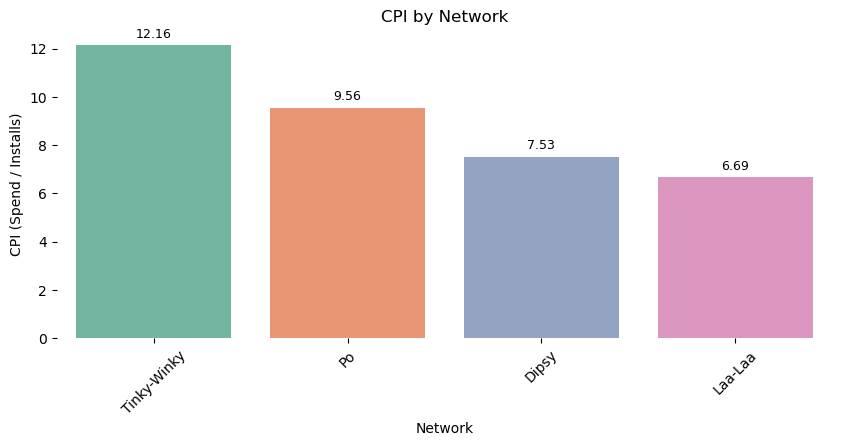

In [17]:
# plot
plt.figure(figsize=(10,4))
ax = sns.barplot(x='Network', y='CPI', data=cpi_by_network_sorted, palette="Set2")
# values
for p in ax.patches: ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                                 ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 3),
                                 textcoords='offset points')
# borders
sns.despine(left=True, bottom=True, right=True, top=True)
# chart
plt.title("CPI by Network")
plt.ylabel("CPI (Spend / Installs)")
plt.xlabel("Network")
plt.xticks(rotation=45)
plt.show();

# 7)

In [18]:
# KPI
df['Payer_Rate'] = (df['Deposits'] / df['Installs']) * 100
# campaign with the highest payer rate
max_payer_rate = df.loc[df['Payer_Rate'].idxmax(), ['Campaign', 'Network', 'Payer_Rate']]
print("Campaign with highest payer rate:")
max_payer_rate

Campaign with highest payer rate:


Campaign      Share Bear
Network            Dipsy
Payer_Rate      6.009335
Name: 1421, dtype: object

In [19]:
# top 5 campaigns by payer rate
top5_payer_rate = df.nlargest(5, 'Payer_Rate')
top5_payer_rate

,Network,Campaign,Ad group ID,Revenue in first 7 days,Revenue in first 90 days,Revenue in 365 days,Installs,Deposits,Spend,ROI_365,Payer_Rate
1421,Dipsy,Share Bear,5264,12683.10,55805.64,126831,1714,103,126492,1.002680,6.009335
1169,Dipsy,Share Bear,6330,1853.49,59311.68,185349,17513,1051,435653,0.425451,6.001256
4194,Po,Lucky Bear,3958,0.00,2482.56,10344,55609,3337,11310,0.914589,6.000827
298,Dipsy,Grumpy Bear,2822,3740.67,97257.42,374067,59646,3579,962832,0.388507,6.000402
2023,Laa-Laa,Friend Bear,7560,22884.54,270800.39,381409,81378,4883,789204,0.483283,6.000393


<div class="alert alert-info"> <b>
    
    The top 5 ad groups with the highest payer rate are shown. Two ad groups belong to the same campaign
    Share Bear under the Dipsy network, but the one with Ad group ID 5264 has the highest payer rate overall.

# 8) a. + b.

In [20]:
# networks performance kpis
network_perf = (df.groupby('Network').agg({'Spend':'sum', 'Revenue in 365 days':'sum', 'Installs':'sum', 'Deposits':'sum'})
                .reset_index())
# KPIs
network_perf['ROI_365'] = network_perf['Revenue in 365 days'] / network_perf['Spend']
network_perf['CPI'] = network_perf['Spend'] / network_perf['Installs']
network_perf['Payer_Rate'] = (network_perf['Deposits'] / network_perf['Installs']) * 100
network_perf

,Network,Spend,Revenue in 365 days,Installs,Deposits,ROI_365,CPI,Payer_Rate
0,Dipsy,704784485,438779042,93575318,2966008,0.622572,7.531735,3.169648
1,Laa-Laa,103646556,62456157,15482863,471434,0.602588,6.694276,3.044876
2,Po,712272711,448505591,74487643,2399399,0.629682,9.562294,3.221204
3,Tinky-Winky,519810335,327620278,42754637,1379346,0.630269,12.157987,3.226190


<div class="alert alert-info"> <b>
    
    The network to cut would be Laa-Laa, it has the lowest CPI and delivers the lowest ROI and the weakest payer rate.
    The cheap installs coming from Laa-Laa don't convert into paying users effectively, the poor quality of users
    drives its underperformance.

# 9)

<div class="alert alert-info"> <b>
    
    Best metrics to check a campaign:
    ROI (365 days) shows if the money we spent brings back enough revenue.
    Payer Rate shows how many installs actually become payers.
    
    Pros and cons
    ROI
    Pros: Tells us if the campaign is profitable.
    Cons: Takes a long time to measure (full year).
    
    Payer Rate
    Pros: Shows quality of users not just quantity.
    Cons: Doesn’t tell us how much those users spend.
    
    CPI
    Pros: Easy to track and shows cost per install.
    Cons: Cheap installs may still bring low value.
    
    Extra data
    Retention (D1, D7, D30)
    Example: Two campaigns both have 10% payer rate.
    Campaign A, players leave after 2 days, while in Campaign B, they stay for months
    Retention shows which campaign brings loyal users.
    
    ARPPU / LTV
    Example: Campaign X has 100 payers who each spend 5$, Campaign Y has 50 payers who each spend $50.
    Even with fewer payers, Campaign Y is much better because of higher value per user.

# Part III:	Business

# 10)

<div class="alert alert-info"> <b>
    
    Tinky-Winky had the highest ROI and the highest payer rate, even though its CPI was the most expensive.
    This means installs cost more, but they convert better and spend more, making the network profitable.
    Laa-Laa looked the weakest, cheap installs but low ROI and low payer rate leads to bad quality.
    
    Missing data
    Retention / Engagement (D7, D30, D90)
    If users from another game (for example Dipsy) stay longer and spend over time, ROI could improve later, without
    retention, we may underestimate players who pay later.
    
    ARPPU / LTV
    It might turn out another game has fewer payers but much higher spending per payer, for example: Po could have
    lower ROI now, but with higher ARPPU, it might pass others long term.